In [ ]:
is_colab = False
import sys
if is_colab:
    try:
        import torch  
        print('Module torch was installed')
    except ImportError:    
        print("Installinng torch 1.8.1")
        !pip install -q torch==1.8.1
    try:
        import torchvision  
        print('Module torchvision was installed')
    except ImportError:    
        print("Installinng torchvision 0.4.0")
        !pip install -q torchvision==0.4.0
    
    try:
        import qiskit  
        print('Module qiskit was installed')
    except ImportError:    
        print("Installinng qiskit 0.14.0")
        !pip install -q qiskit==0.14.0

    !pip install JQuantumFlow==0.0.5

import numpy as np
import torch
import torchvision
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit.extensions import XGate, UnitaryGate
import qiskit
import math

from JQuantumFlow.training.lib_dataloader import load_data,to_quantum_matrix,ToQuantumData
from JQuantumFlow.circuit.lib_gate import ExtendGate
from JQuantumFlow.circuit.lib_qiskit_commons import fire_ibmq,analyze

In [ ]:

################ Zhirui on 12-30-2020 ################
# Parameters of settings
######################################################
interest_num = [3,6]
img_size = 4
 # how many samples per batch 
batch_size = 1 
inference_batch_size = 1


################ Zhirui on 12-30-2020 ################
# path
######################################################
if is_colab:
    data_path = '/content/data' #mnist  path
else: 
    data_path = '/home/hzr/Software/quantum/qc_mnist/pytorch/data'

################ Zhirui on 12-30-2020 ################
#load data and do data preparation
######################################################

train_loader, test_loader = load_data(interest_num,data_path,False,img_size,batch_size,inference_batch_size,False)

for batch_idx, (data, target) in enumerate(test_loader):
    torch.set_printoptions(threshold=sys.maxsize)
    print("Batch Id: {}, Target: {}".format(batch_idx,target))
    quantum_matrix = to_quantum_matrix(data)
    to_quantum_data = ToQuantumData(img_size)
    quantum_data = to_quantum_data(data)
    break


Batch Id: 0, Target: tensor([1])


Here, we appiled the tained weights obtained from QF-FB, which will be introduced in the later tutorial. 
But, at this moment, feel free to change the weights to see the circuit depth comparison.

For eaxmple, the following weights will lead the depth comparison to be 93:33.
<pre><code>weight_1_1 = torch.tensor([1.,  -1.,  -1.,  1.,  -1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,    1.,  1.])
weight_1_2 = torch.tensor([-1., -1., -1., -1., -1., 1., 1., -1., -1.,  1., -1.,  1., -1., -1.,-1., -1.])</code></pre> 

In [ ]:
################ Weiwen on 12-30-2020 ################
# Parameters of the trained model
# The training procedure will be found in another repo
# https://github.com/weiwenjiang/QuantumFlow
######################################################

# Model initialization
weight_1_1 = torch.tensor([1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,    1.,  1.])
weight_1_2 = torch.tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1., -1.,-1., -1.])

weight_2_1 = torch.tensor([1.,  -1.])
norm_flag_1 = True
norm_para_1 = torch.tensor(0.3060)

weight_2_2 = torch.tensor([-1.,  -1.])
norm_flag_2 = False
norm_para_2 = torch.tensor(0.6940)

### Optimized Circuit

In the following, the optimized circuit (opt_circ) is created

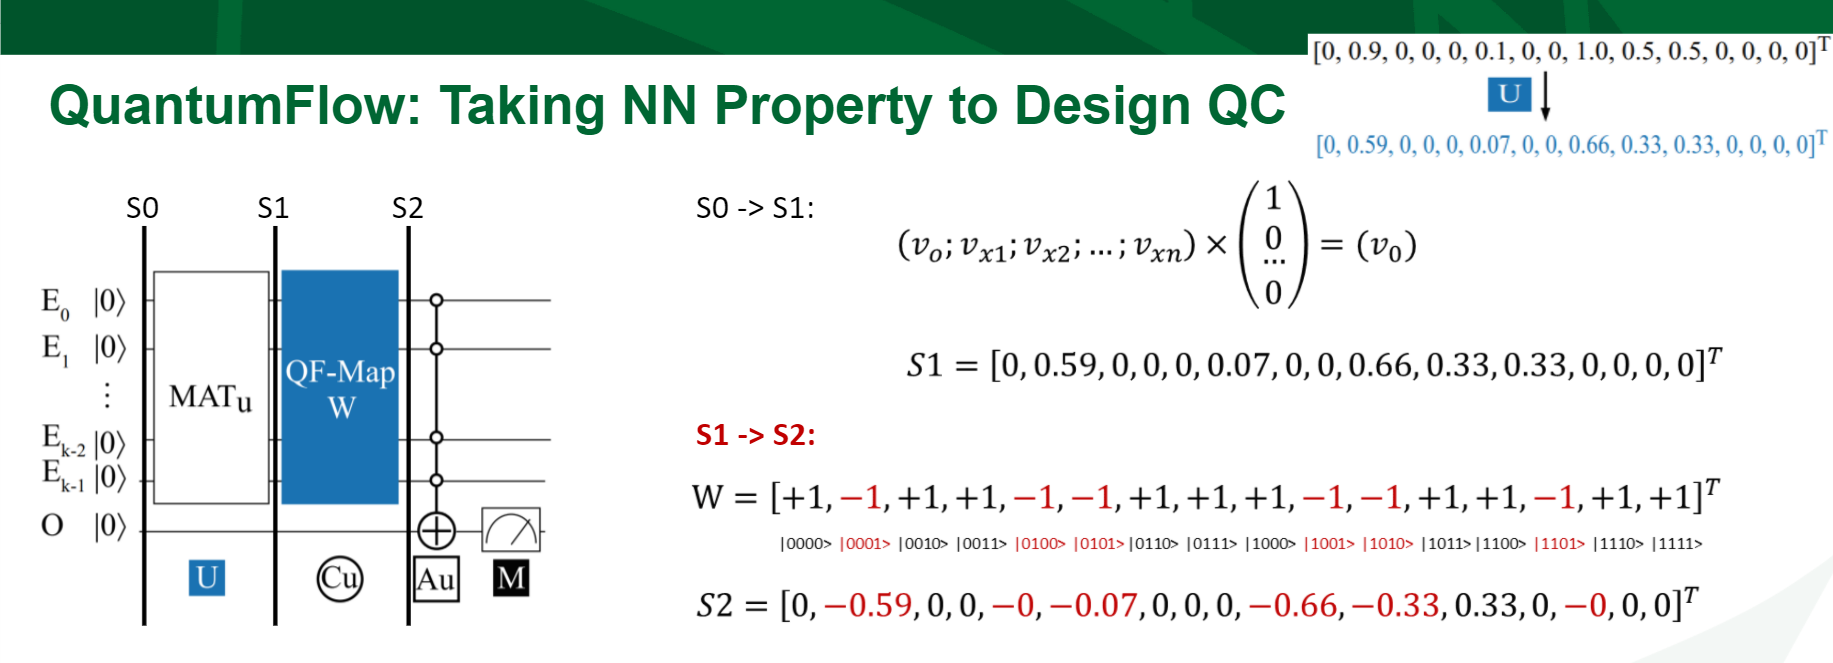

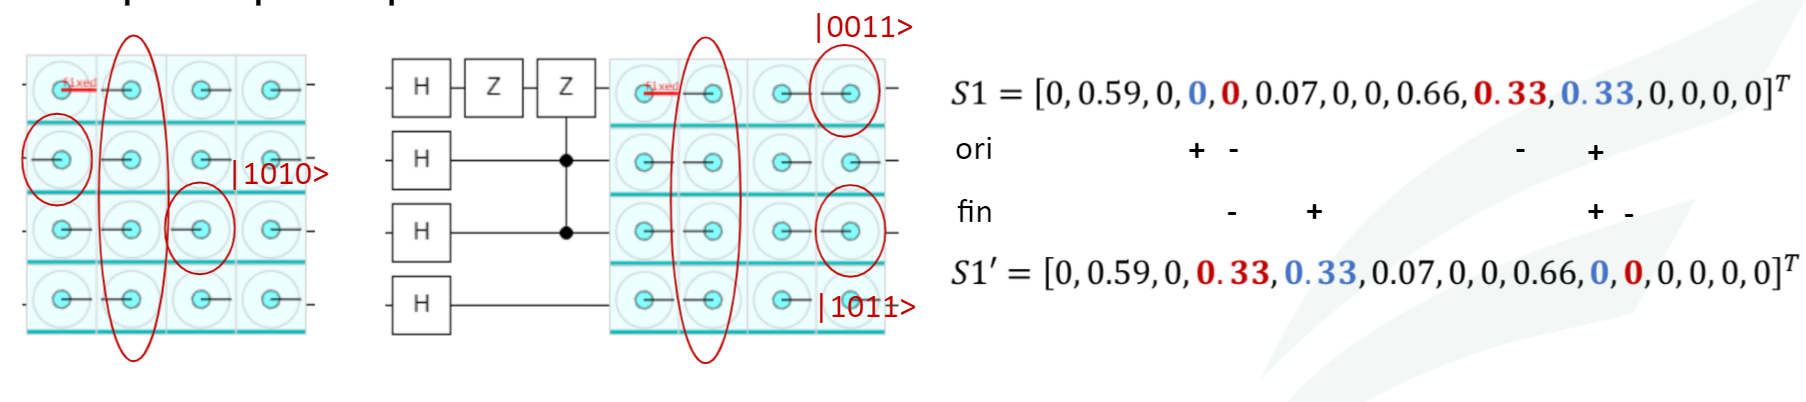

In [ ]:
################ Weiwen on 06-02-2021 ################
# QuantumFlow Weight Generation for U-Layer
######################################################

def get_index_list(input,target):
    index_list = []
    try:
        beg_pos = 0
        while True:
            find_pos = input.index(target,beg_pos)
            index_list.append(find_pos)
            beg_pos = find_pos+1
    except Exception as exception:        
        pass    
    return index_list
#
def change_sign(sign,bin):
    affect_num = [bin]
    one_positions = []
    print("bin :",bin)
    try:
        beg_pos = 0
        while True:
            find_pos = bin.index("1",beg_pos)
            one_positions.append(find_pos)
            beg_pos = find_pos+1
    except Exception as exception:
        # print("Not Found")
        pass
    for k,v in sign.items():
        change = True
        for pos in one_positions:
            if k[pos]=="0":                
                change = False
                break
        if change:
            sign[k] = -1*v
    

def find_start(affect_count_table,target_num):
    for k in list(affect_count_table.keys())[::-1]:
        if target_num<=k:
            return k


def recursive_change(direction,start_point,target_num,sign,affect_count_table,quantum_gates):
    
    if start_point == target_num:
        # print("recursive_change: STOP")
        return
    
    gap = int(math.fabs(start_point-target_num))    
    step = find_start(affect_count_table,gap)
    change_sign(sign,affect_count_table[step])
    quantum_gates.append(affect_count_table[step])
    
    if direction=="r": 
        # print("recursive_change: From",start_point,"Right(-):",step)
        start_point = start_point - step
        direction = "l"
        recursive_change(direction,start_point,target_num,sign,affect_count_table,quantum_gates)
        
    else:        
        # print("recursive_change: From",start_point,"Left(+):",step)
        start_point = start_point + step
        direction = "r"
        recursive_change(direction,start_point,target_num,sign,affect_count_table,quantum_gates)
        
    

def guarntee_upper_bound_algorithm(sign,target_num,total_len,digits):        
    flag = "0"+str(digits)+"b"
    pre_num = 0
    affect_count_table = {}
    quantum_gates = []
    for i in range(digits):
        cur_num = pre_num + pow(2,i)
        pre_num = cur_num
        binstr_cur_num = format(cur_num,flag) 
        affect_count_table[int(pow(2,binstr_cur_num.count("0")))] = binstr_cur_num   
    
    if target_num in affect_count_table.keys():
        quantum_gates.append(affect_count_table[target_num])
        change_sign(sign,affect_count_table[target_num])  
  
    else:
        direction = "r"
        start_point = find_start(affect_count_table,target_num)
        quantum_gates.append(affect_count_table[start_point])
        change_sign(sign,affect_count_table[start_point])
        recursive_change(direction,start_point,target_num,sign,affect_count_table,quantum_gates)
    
    return quantum_gates


    



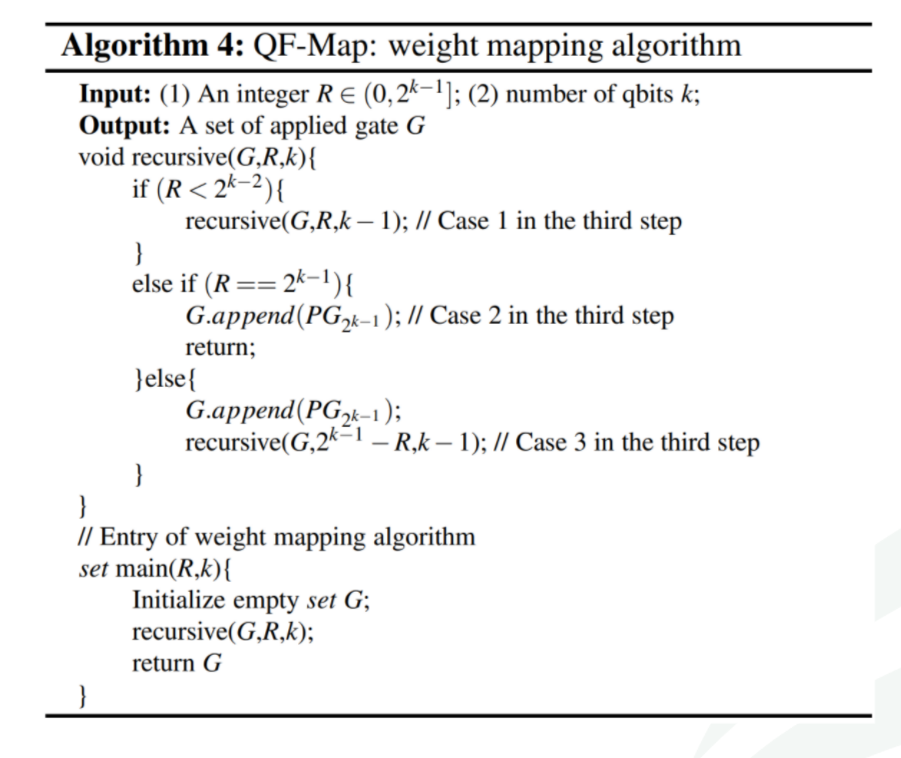

In [ ]:
def qf_map_extract_from_weight(weights):    
    # Find Z control gates according to weights
    w = (weights.detach().cpu().numpy())
    total_len = len(w)
    target_num = np.count_nonzero(w == -1)
    if target_num > total_len/2:
        w = w*-1
    target_num = np.count_nonzero(w == -1)    
    digits = int(math.log(total_len,2))
    flag = "0"+str(digits)+"b"
    max_num = int(math.pow(2,digits))
    sign = {}
    for i in range(max_num):        
        sign[format(i,flag)] = +1

    quantum_gates = guarntee_upper_bound_algorithm(sign,target_num,total_len,digits)
    
    # Build the mapping from weight to final negative num 
    fin_sign = list(sign.values())
    fin_weig = [int(x) for x in list(w)]
    sign_neg_index = []    
    try:
        beg_pos = 0
        while True:
            find_pos = fin_sign.index(-1,beg_pos)            
            # qiskit_position = int(format(find_pos,flag)[::-1],2)                            
            sign_neg_index.append(find_pos)
            beg_pos = find_pos+1
    except Exception as exception:        
        pass  
    

    weight_neg_index = []
    try:
        beg_pos = 0
        while True:
            find_pos = fin_weig.index(-1,beg_pos)
            weight_neg_index.append(find_pos)
            beg_pos = find_pos+1
    except Exception as exception:        
        pass    

    map = {}
    for i in range(len(sign_neg_index)):
        map[sign_neg_index[i]] = weight_neg_index[i]

    ret_index = list([-1 for i in range(len(fin_weig))])
    
    
    for k,v in map.items():
        ret_index[k]=v
    
    
    for i in range(len(fin_weig)):
        if ret_index[i]!=-1:
            continue
        for j in range(len(fin_weig)):
            if j not in ret_index:
                ret_index[i]=j
                break
    return quantum_gates,ret_index

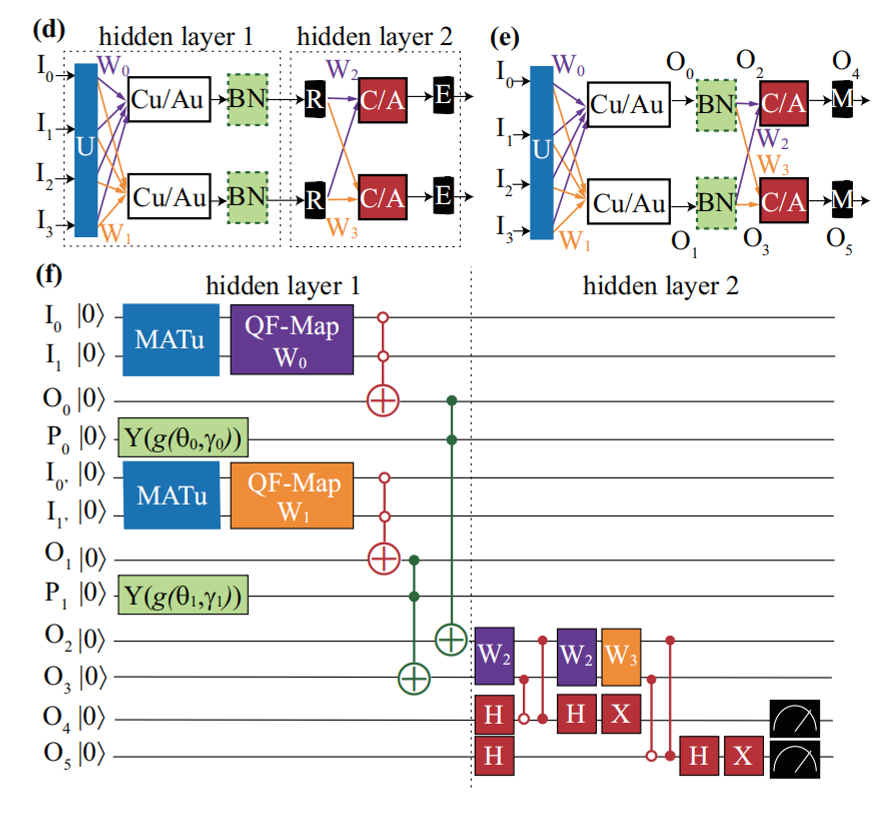

In [ ]:
# Optimized circuit

# From Listing 2: creat the qubits to hold data
inp_1 = QuantumRegister(4,"in1_qbit")
inp_2 = QuantumRegister(4,"in2_qbit")
opt_circ = QuantumCircuit(inp_1,inp_2)
data_matrix = quantum_matrix

n1_q_gates,n1_idx = qf_map_extract_from_weight(weight_1_1)
n2_q_gates,n2_idx = qf_map_extract_from_weight(weight_1_2)
 
print('n1_idx:',n1_idx)
opt_circ.append(UnitaryGate(data_matrix[n1_idx], label="Input"), inp_1[0:4])
opt_circ.append(UnitaryGate(data_matrix[n2_idx], label="Input"), inp_2[0:4])

# From Listing 3: create auxiliary qubits
aux = QuantumRegister(2,"aux_qbit")
opt_circ.add_register(aux)

# From Listing 4: create output qubits for the first layer (hidden neurons)
hidden_neurons = QuantumRegister(2,"hidden_qbits")
opt_circ.add_register(hidden_neurons)


qbits = inp_1
for gate in n1_q_gates:
    z_count = gate.count("1")
    # z_pos = get_index_list(gate,"1")
    z_pos = get_index_list(gate[::-1],"1")
    # print(z_pos)
    if z_count==1:
        opt_circ.z(qbits[z_pos[0]])
    elif z_count==2:
        opt_circ.cz(qbits[z_pos[0]],qbits[z_pos[1]])
    elif z_count==3:
        ExtendGate.ccz(opt_circ,qbits[z_pos[0]],qbits[z_pos[1]],qbits[z_pos[2]],aux[0])
    elif z_count==4:
        ExtendGate.cccz(opt_circ,qbits[z_pos[0]],qbits[z_pos[1]],qbits[z_pos[2]],qbits[z_pos[3]],aux[0],aux[1])

qbits = inp_2
for gate in n2_q_gates:
    z_count = gate.count("1")
    # z_pos = get_index_list(gate,"1")
    z_pos = get_index_list(gate[::-1],"1")
    # print(z_pos)
    if z_count==1:
        opt_circ.z(qbits[z_pos[0]])
    elif z_count==2:
        opt_circ.cz(qbits[z_pos[0]],qbits[z_pos[1]])
    elif z_count==3:
        ExtendGate.ccz(opt_circ,qbits[z_pos[0]],qbits[z_pos[1]],qbits[z_pos[2]],aux[0])
    elif z_count==4:
        ExtendGate.cccz(opt_circ,qbits[z_pos[0]],qbits[z_pos[1]],qbits[z_pos[2]],qbits[z_pos[3]],aux[0],aux[1])

opt_circ.barrier()

# From Listing 4: applying the quadratic function on the weighted sum
opt_circ.h(inp_1)
opt_circ.x(inp_1)
ExtendGate.ccccx(opt_circ,inp_1[0],inp_1[1],inp_1[2],inp_1[3],hidden_neurons[0],aux[0],aux[1])

opt_circ.h(inp_2)
opt_circ.x(inp_2)
ExtendGate.ccccx(opt_circ,inp_2[0],inp_2[1],inp_2[2],inp_2[3],hidden_neurons[1],aux[0],aux[1])


print("Hidden layer created!")

bin : 0011
bin : 1111
bin : 0111
n1_idx: [0, 1, 2, 7, 3, 4, 5, 9, 6, 8, 10, 11, 12, 13, 14, 15]
Hidden layer created!


In [ ]:
################ Weiwen on 12-30-2020 ################
# Quantum circuit implementation of the output layer
# fundamentals, please see our Nature Communication
# paper (P-LYR) https://arxiv.org/pdf/2006.14815.pdf
######################################################

inter_q_1 = QuantumRegister(1,"inter_q_1_qbits")
norm_q_1 = QuantumRegister(1,"norm_q_1_qbits")
out_q_1 = QuantumRegister(1,"out_q_1_qbits")
opt_circ.add_register(inter_q_1,norm_q_1,out_q_1)

opt_circ.barrier()

if weight_2_1.sum()<0:
    weight_2_1 = weight_2_1*-1
idx = 0
for idx in range(weight_2_1.flatten().size()[0]):
    if weight_2_1[idx]==-1:
        opt_circ.x(hidden_neurons[idx])
opt_circ.h(inter_q_1)
opt_circ.cz(hidden_neurons[0],inter_q_1)
opt_circ.x(inter_q_1)
opt_circ.cz(hidden_neurons[1],inter_q_1)
opt_circ.x(inter_q_1)
opt_circ.h(inter_q_1)
opt_circ.x(inter_q_1)

opt_circ.barrier()

norm_init_rad = float(norm_para_1.sqrt().arcsin()*2)
opt_circ.ry(norm_init_rad,norm_q_1)
if norm_flag_1:
    opt_circ.cx(inter_q_1,out_q_1)
    opt_circ.x(inter_q_1)
    opt_circ.ccx(inter_q_1,norm_q_1,out_q_1)
else:
    opt_circ.ccx(inter_q_1,norm_q_1,out_q_1)

for idx in range(weight_2_1.flatten().size()[0]):
    if weight_2_1[idx]==-1:
        opt_circ.x(hidden_neurons[idx])

opt_circ.barrier()




inter_q_2 = QuantumRegister(1,"inter_q_2_qbits")
norm_q_2 = QuantumRegister(1,"norm_q_2_qbits")
out_q_2 = QuantumRegister(1,"out_q_2_qbits")
opt_circ.add_register(inter_q_2,norm_q_2,out_q_2)

opt_circ.barrier()

if weight_2_2.sum()<0:
    weight_2_2 = weight_2_2*-1
idx = 0
for idx in range(weight_2_2.flatten().size()[0]):
    if weight_2_2[idx]==-1:
        opt_circ.x(hidden_neurons[idx])
opt_circ.h(inter_q_2)
opt_circ.cz(hidden_neurons[0],inter_q_2)
opt_circ.x(inter_q_2)
opt_circ.cz(hidden_neurons[1],inter_q_2)
opt_circ.x(inter_q_2)
opt_circ.h(inter_q_2)
opt_circ.x(inter_q_2)

opt_circ.barrier()

norm_init_rad = float(norm_para_2.sqrt().arcsin()*2)
opt_circ.ry(norm_init_rad,norm_q_2)
if norm_flag_2:
    opt_circ.cx(inter_q_2,out_q_2)
    opt_circ.x(inter_q_2)
    opt_circ.ccx(inter_q_2,norm_q_2,out_q_2)
else:
    opt_circ.ccx(inter_q_2,norm_q_2,out_q_2)

for idx in range(weight_2_2.flatten().size()[0]):
    if weight_2_2[idx]==-1:
        opt_circ.x(hidden_neurons[idx])

opt_circ.barrier()

c_reg = ClassicalRegister(2,"reg")
opt_circ.add_register(c_reg)
opt_circ.measure(out_q_1,c_reg[0])
opt_circ.measure(out_q_2,c_reg[1])

print("Output layer created!")

Output layer created!


### Optimized Circuit

Let's test!


In [ ]:
################ Weiwen on 12-30-2020 ################
# Quantum simulation
######################################################

qc_shots=8192
opt_counts = fire_ibmq(opt_circ,qc_shots,True)
(opt_mycount,bits) = analyze(opt_counts)
opt_class_prob=[]
for b in range(bits):
    opt_class_prob.append(float(opt_mycount[b])/qc_shots)


print("="*10,"Optimized Circuit","="*10)
print("Result of optimized QC:",opt_class_prob)
print("Prediction class: {}".format(opt_class_prob.index(max(opt_class_prob))))
print("Target class: {}".format(target[0]))
if opt_class_prob.index(max(opt_class_prob))==target[0]:
    print("Correct prediction")
else:
    print("Incorrect prediction")
print("="*30)

========== Optimized Circuit ==========
Result of optimized QC: [0.4420166015625, 0.55322265625]
Prediction class: 1
Target class: 1
Correct prediction
